In [1]:
%load_ext autoreload
%autoreload 2
import pickle as pkl
from os.path import join as oj

import figs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import sklearn.linear_model
import torch
import viz

PROCESSED_DIR = 'processed'
RESULTS_DIR = 'results'
DIRECTIONS_DIR = '../data/annotation-dataset-stylegan2/linear_models/new' # path to many datasets, includes on directory before the below dirs
GENERATING_LATENTS_DIR = '../data/annotation-dataset-stylegan2/data'

# loading

In [2]:
latents = np.load(oj(GENERATING_LATENTS_DIR, 'W.npy'))
annotations_dict = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_dict.pkl'), 'rb'))
annotations_dict_names = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_labels_dict.pkl'), 'rb'))

# rename keys
annotations_dict = {k.replace('calibration-random-v2-', '').replace('-000', ''): annotations_dict[k]
                    for k in annotations_dict}
# attrs = ['age', 'facial-hair', 'skin-color', 'gender', 'hair-length', 'makeup']
attrs = ['skin-color', 'gender', 'hair-length']
N_A = len(attrs)

attr_mat = np.array([annotations_dict[attr].mean(axis=1) for attr in attrs]).transpose()
attr_mat = (attr_mat - attr_mat.mean(axis=0)) / attr_mat.std(axis=0)
X = latents
Y = np.zeros(latents.shape) # pad Y with zeros, only first N rows have attributes
Y[:, :N_A] = attr_mat
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, Y, test_size=0.3, random_state=42)

**run by changing params in fit_inn.py**

In [70]:
# fname = '07_df_loss_tradeoff_nonlinear_INN_3lay'
# df.to_pickle(oj(PROCESSED_DIR, fname + '.pkl'))
# torch.save(m.state_dict(), oj(PROCESSED_DIR, fname + '.weights'))
# pkl.dump(p, open(oj(PROCESSED_DIR, fname + '_params.pkl'), 'wb'))

In [ ]:
figs.plot_mse_vs_corrs()

**we are plotting mse but spearman corr probably makes more sense**

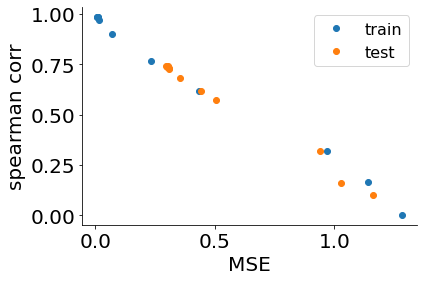

In [123]:
df = pd.read_pickle(oj(PROCESSED_DIR, '07_relu_retrain_3lay_noise_big.pkl'))
plt.plot(df['mse'], df['spearman'], 'o', label='train')
plt.plot(df['mse_test'], df['spearman_test'], 'o', label='test')
# plt.xlim((0, 0.6))
# plt.ylim((0.5, 1.0))
plt.xlabel('MSE')
plt.ylabel('spearman corr')
plt.legend()
plt.show()

In [128]:
preds_train = m(torch.Tensor(X_train)).detach().numpy()
preds_test = m(torch.Tensor(X_test)).detach().numpy()
print('shapes', preds_train.shape, preds_test.shape)

shapes (3500, 6) (1500, 6)


-0.06701056051352683
-0.0560786178909151
-0.007059932797258937
0.05037832516859507
0.03442539077078464
-0.03800710654858129


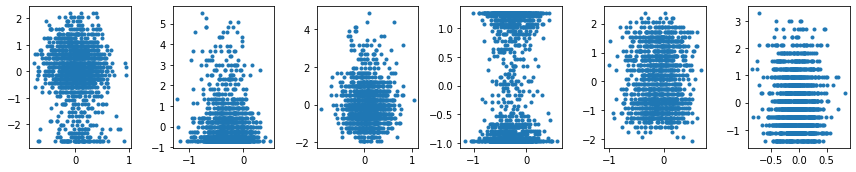

In [129]:
R, C = 1, 6
plt.figure(figsize=(12, 2.5))
for i in range(6):
    plt.subplot(R, C, i + 1)
    plt.plot(preds_test[:, i], y_test[:, i], '.')
    print(scipy.stats.spearmanr(preds_test[:, i], y_test[:, i]).correlation)

plt.tight_layout()
plt.show()

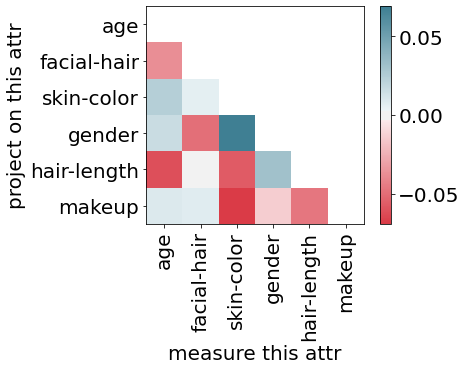

In [135]:
viz.corrplot(np.corrcoef(preds_test.transpose()))
plt.xticks(range(N), attrs, rotation='vertical')
plt.ylabel('project on this attr')
plt.xlabel('measure this attr')
plt.yticks(range(N), attrs)
plt.colorbar()
plt.show()